<a href="https://colab.research.google.com/github/serg-kas/COCO_Zebra/blob/main/Image_generation_with_zebras_by_mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Задача используя базу данных COCO для сегментации, сделать **генерацию изображений с зебрами**. 
Для генерации можно  маску сегментации зебры в качестве условия.

In [ ]:
import numpy as np

import scipy

from keras.models import Sequential, Model
from tensorflow.python.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, LeakyReLU
from tensorflow.python.keras.layers import BatchNormalization, Add, add
from tensorflow.python.keras.layers import UpSampling2D, Conv2D
from tensorflow.python.keras.applications import vgg19
from keras.preprocessing.image import img_to_array, load_img
from keras.optimizers import Adam
import tensorflow.python.keras.backend as K
from keras.utils import plot_model

import os
from google.colab import drive 

from tqdm import tqdm
import matplotlib.pyplot as plt
#from PIL import Image

#отключаем отображение некритических предупреждений
from tensorflow.python.platform.tf_logging import set_verbosity, FATAL
set_verbosity(FATAL)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '0'

In [ ]:
#подключаем google drive
from google.colab import drive 
drive.mount('/content/drive')                           

Mounted at /content/drive


### Загрузка данных из COCO dataset

In [ ]:
from pycocotools.coco import COCO
import skimage.io as io
import requests

In [ ]:
# Разархивируем скачанный с COCO файл с аннотациями в колаб

!unzip -q '/content/drive/My Drive/my_sample_data/COCO_Zebra/annotations_trainval2017.zip'

!ls annotations

replace annotations/instances_train2017.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
captions_train2017.json   instances_val2017.json
captions_val2017.json	  person_keypoints_train2017.json
instances_train2017.json  person_keypoints_val2017.json


In [ ]:
# Создаем экземпляр COCO на основе пути к файлу с аннотациями
coco = COCO('./annotations/instances_train2017.json')

loading annotations into memory...
Done (t=13.64s)
creating index...
index created!


In [ ]:
# посмотрим категории и суперкатегории COCO 
cats = coco.loadCats(coco.getCatIds())
nms= [cat['name'] for cat in cats]
print('COCO категории: \n{}\n'.format(' '.join(nms)))

nms = [cat['supercategory'] for cat in cats]
print('COCO суперкатегории: \n{}'.format(' '.join(nms)))

COCO категории: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO суперкатегории: 
person vehicle vehicle vehicle vehicle vehicle vehicle vehicle vehicle outdoor outdoor outdoor outdoor outdoor animal animal animal animal animal animal animal animal animal animal accessory accessory accessory accessory accessory sports sports sports sports sports sports sports sports sports sports kitchen kitchen kitchen kitchen kitche

In [ ]:
# Получим все картинки из заданной категории
catIds = coco.getCatIds(catNms=['zebra'])
imgIds = coco.getImgIds(catIds=catIds )

print('Нашлось {} картинок в категории {}'.format(len(imgIds), 'zebra'))

images = coco.loadImgs(imgIds)         #список с данными картинок (список словарей)

Нашлось 1916 картинок в категории zebra


http://images.cocodataset.org/train2017/000000470411.jpg


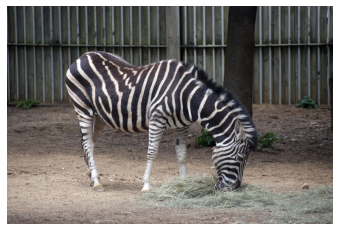

(428, 640, 3)


In [ ]:
#Посмотрим cлучайную картинку
image = images[np.random.randint(0,len(imgIds))]
print(image['coco_url'])

Im = io.imread(image['coco_url'])       #картинка тут == numpy массив
plt.axis('off')
plt.imshow(Im)
plt.show()

print(Im.shape)

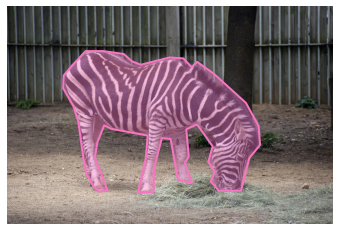

In [ ]:
# загрузим и посмотрим разметку (аннотацию) изображения 
plt.imshow(Im)
plt.axis('off')

#получаем индекс аннотации по индексу картинки
annIds = coco.getAnnIds(imgIds=image['id'], catIds=catIds, iscrowd=None)
#получаем аннотацию по индексу
anns = coco.loadAnns(annIds)
#смотрим аннотацию
coco.showAnns(anns)

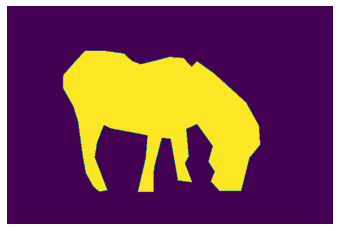

(428, 640)


In [ ]:
# посмотрим маску, преобразованную из векторного формата

Msk = coco.annToMask(anns[0])              #маска тут == numpy массив

plt.axis('off')
plt.imshow(Msk)
plt.show()

print(Msk.shape)


In [ ]:
# Сохраняем изображения в папку на гугл диске 

#for im in images:
#  img_data = requests.get(im['coco_url']).content
#  with open('/content/drive/My Drive/my_sample_data/COCO_Zebra/zebra_images/' + im['file_name'], 'wb') as handler:
#    handler.write(img_data)

In [ ]:
# Сохраняем маски в папку на гугл диске 
for im in images:
  annIds = coco.getAnnIds(imgIds=im['id'], catIds=catIds, iscrowd=None)
  anns = coco.loadAnns(annIds)
  img_mask = coco.annToMask(anns[0])  

  #Для повышения контраста картинки (исходно маска состоит из 0 и 1)
  img_mask *= 200
  
  io.imsave('/content/drive/My Drive/my_sample_data/COCO_Zebra/zebra_masks/' + im['file_name'], img_mask)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: /content/drive/My Drive/my_sample_data/COCO_Zebra/zebra_masks/000000327695.jpg is a low contrast image
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: /content/drive/My Drive/my_sample_data/COCO_Zebra/zebra_masks/000000376875.jpg is a low contrast image
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: /content/drive/My Drive/my_sample_data/COCO_Zebra/zebra_masks/000000524373.jpg is a low contrast image
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: /content/drive/My Drive/my_sample_data/COCO_Zebra/zebra_masks/000000401561.jpg is a low contrast image
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py

**Примечание:** можно было не сохранять картинки на гугл диск, а сразу обрабатывать в колабе. Но я на всякий случай сделал промежуточное сохранение.
 



In [ ]:
#Изображения приведем к одному размеру

img_shape = (256,384,3) 

height=img_shape[0]
width=img_shape[1]

imgs_dir = '/content/drive/My Drive/my_sample_data/COCO_Zebra/zebra_images/'
mask_dir = '/content/drive/My Drive/my_sample_data/COCO_Zebra/zebra_masks/'

In [ ]:
imgs = [] 
#проходим по каждому файлу, получив список файлов в папке 
for image in sorted(os.listdir(imgs_dir)): 
  print(image)
  imgs.append(img_to_array(load_img(imgs_dir+image, target_size=(height,width)))) #загружаем файл, устанавливаем нужный размер и сохраняем в оперативную память, как массив numpy
imgs = np.stack(imgs).astype('uint8') #сохраняем итоговый массив изображений

masks = []
#проходим по каждому файлу, получив список файлов в папке 
for image in sorted(os.listdir(mask_dir)): 
  print(image)
  masks.append(img_to_array(load_img(mask_dir+image, target_size=(height,width)))) #загружаем файл, устанавливаем нужный размер и сохраняем в оперативную память, как массив numpy
masks = np.stack(masks).astype('uint8') #сохраняем итоговый массив масок

000000000034.jpg
000000000154.jpg
000000000827.jpg
000000001228.jpg
000000001501.jpg
000000001777.jpg
000000001907.jpg
000000002232.jpg
000000002684.jpg
000000003867.jpg
000000004318.jpg
000000004508.jpg
000000004754.jpg
000000005344.jpg
000000005362.jpg
000000006450.jpg
000000006599.jpg
000000006688.jpg
000000007522.jpg
000000007566.jpg
000000008290.jpg
000000008320.jpg
000000009214.jpg
000000009548.jpg
000000009709.jpg
000000009988.jpg
000000010077.jpg
000000010211.jpg
000000010327.jpg
000000010702.jpg
000000010733.jpg
000000010822.jpg
000000011554.jpg
000000011926.jpg
000000011948.jpg
000000012382.jpg
000000012495.jpg
000000012750.jpg
000000012756.jpg
000000013150.jpg
000000013356.jpg
000000013517.jpg
000000013948.jpg
000000014276.jpg
000000014377.jpg
000000014820.jpg
000000014862.jpg
000000014998.jpg
000000015301.jpg
000000015565.jpg
000000015595.jpg
000000015618.jpg
000000016575.jpg
000000016706.jpg
000000016716.jpg
000000016825.jpg
000000017089.jpg
000000017324.jpg
000000017604.j

In [ ]:
print(imgs.shape)
print(masks.shape)

(1916, 256, 384, 3)
(1916, 256, 384, 3)


In [ ]:
# Сохраняем/Загружаем подготовленные выборки (массивы) с гугл-диска

np.save('/content/drive/My Drive/my_sample_data/COCO_Zebra/imgs', imgs)
np.save('/content/drive/My Drive/my_sample_data/COCO_Zebra/masks', masks)

imgs = np.load('/content/drive/My Drive/my_sample_data/COCO_Zebra/imgs.npy')
masks = np.load('/content/drive/My Drive/my_sample_data/COCO_Zebra/masks.npy')

print(imgs.shape)
print(masks.shape)

(1916, 256, 384, 3)
(1916, 256, 384, 3)


In [ ]:
def build_generator():
    gf = 64 #минимальное число фильтров
    

    def conv2d(layer_input, filters, f_size=4, bn=True): #слой с понижением разрешения (encoder)
        
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input) #strides = 2 уменьшает разрешение в 2 раза при padding='same'
        d = LeakyReLU(alpha=0.2)(d)
        if bn:
            d = BatchNormalization(momentum=0.8)(d)
        return d

    def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0): #слой с повышением разрешения (decoder) принимает на вход предыдущий слой и skip-слой от encoder'а
        u = UpSampling2D(size=2)(layer_input) #увеличивам разрешение в 2 раза
        u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u) #strides=1, padding='same',  поэтому разрешение сохраняется
        if dropout_rate:
            u = Dropout(dropout_rate)(u)
        u = BatchNormalization(momentum=0.8)(u)
        u = Concatenate()([u, skip_input]) #соединяем skip-слой и слой decoder'а
        return u

    
    d0 = Input(shape=img_shape, name="condition") #входное изображение (условие)

    # Часть encoder'a
    d1 = conv2d(d0, gf, bn=False)
    d2 = conv2d(d1, gf*2)
    d3 = conv2d(d2, gf*4) #чем меньше размер карт активаций
    d4 = conv2d(d3, gf*8) #тем больше должно быть фильтров в сверточном слое
    d5 = conv2d(d4, gf*8)
    d6 = conv2d(d5, gf*8)
    d7 = conv2d(d6, gf*8)

    # Часть decoder'a
    u1 = deconv2d(d7, d6, gf*8)
    u2 = deconv2d(u1, d5, gf*8) 
    u3 = deconv2d(u2, d4, gf*8) #чем больше размер карт активаций
    u4 = deconv2d(u3, d3, gf*4) #тем меньше должно быть фильтров в сверточном слое
    u5 = deconv2d(u4, d2, gf*2)
    u6 = deconv2d(u5, d1, gf)

    u7 = UpSampling2D(size=2)(u6)
    output_img = Conv2D(3, kernel_size=4, strides=1, padding='same', activation='tanh', name='G_output')(u7) #интенсивность должна быть от -1 до 1, поэтому используем tanh

    return Model(d0, output_img, name="G")

In [ ]:
gen = build_generator() #создаем генератор
gen.summary()

Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
condition (InputLayer)          [(None, 256, 384, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 192, 64) 3136        condition[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 192, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 96, 128)  131200      leaky_re_lu[0][0]                
__________________________________________________________________________________________________

In [ ]:
def build_discriminator():
  
  df = 64 #минимальное число фильтров
  def d_layer(layer_input, filters, f_size=4, bn=True): #слой дискриминатора с понижением разрешения
      
      d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input) #размер карт активаций будет уменьшен в 2 раза, так как strides=2 при padding='same'
      d = LeakyReLU(alpha=0.2)(d)
      if bn:
          d = BatchNormalization(momentum=0.8)(d)
      return d

  image = Input(shape=img_shape, name="real_or_fake_A") #на вход дискриминатору подается либо реальное изображение, либо фейковое
  condition = Input(shape=img_shape, name="condition") #и дополнительно изображение-условие

  combined_imgs = Concatenate(axis=-1)([image, condition]) #объединяем оба входа в 1 слой

  d1 = d_layer(combined_imgs, df, bn=False)
  d2 = d_layer(d1, df*2)
  d3 = d_layer(d2, df*4) #уменьшаем размер карт активации, увеличивая их число
  d4 = d_layer(d3, df*8)

  validity = Conv2D(1, kernel_size=4, strides=1, padding='same', name='D_output', activation='sigmoid')(d4) #на выходе будет двумерный массив, каждый элемент которого определяет, подлинность части изображения (patch GAN)
                                                                                                            #0 отвечает за фейковые изображения, 1 за подлинные, поэтому используем sigmoid

  return Model([image, condition], validity, name='D')

In [ ]:
dis = build_discriminator()
dis.summary()

Model: "D"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
real_or_fake_A (InputLayer)     [(None, 256, 384, 3) 0                                            
__________________________________________________________________________________________________
condition (InputLayer)          [(None, 256, 384, 3) 0                                            
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 256, 384, 6)  0           real_or_fake_A[0][0]             
                                                                 condition[0][0]                  
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 128, 192, 64) 6208        concatenate_6[0][0]              

In [ ]:
def build_vgg():
  #для feature loss создаем vgg модель
  vgg_in = Input(img_shape)
  vgg = vgg19.VGG19(include_top=False, input_shape=img_shape, input_tensor=vgg_in) #скачиваем архитектуру и веса 
  vgg_out = vgg.get_layer('block5_conv4').output #получаем последний сверточный слой
  vgg = Model(vgg_in, vgg_out, name='vgg')
  vgg.trainable = False #модель уже предобучена, поэтому ее необходимо заморозить

  return vgg

In [ ]:
vgg = build_vgg()
vgg.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 384, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 384, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 384, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 192, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 192, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 192, 128)     147584    
________________________________________________________________

In [ ]:
def build_gan(generator, discriminator, vgg):
  discriminator.trainable = False #замораживаем дискриминатор

  condition = Input(img_shape, name='Condition') #вход изображения-условия
  fake_img = generator(condition) #изображение, полученное от генератора

  fake_features = vgg(fake_img) #карты активации, полученные от фейкового изображения

  fake_validity = discriminator([fake_img, condition]) #соединяем генератор и дискриминатор

  gan = Model(condition, [fake_validity, fake_img, fake_features]) #получаем gan с тремя выходами: первый отвечает за "правдоподобность", второй за изображение от генератора, третий за карты активации

  return gan

In [ ]:
def train(generator, discriminator, gan, vgg, imgs, masks, epochs, batch_size):

  for epoch in range(epochs): 
    idx = np.random.choice(imgs.shape[0], imgs.shape[0], replace=False) #перемешиваем индексы, чтобы batch'и всегда были разными

    with tqdm(total=imgs.shape[0]) as pbar: #для отслеживания создаем progressbar
      for batch in range(imgs.shape[0]//batch_size):
        
        #для тренировки дискриминатора применяем label smoothing
        #размерность Y: (размер батча, высота последнего слоя дискриминатора, ширина, 1)
        y_real = np.ones((batch_size, *discriminator.output_shape[1:])) - np.random.random_sample((batch_size, *discriminator.output_shape[1:]))*0.2
        y_fake = np.random.random_sample((batch_size, *discriminator.output_shape[1:]))*0.2

        idx_batch = idx[batch*batch_size:(batch+1)*batch_size] #получаем индексы для одного batch'а

        real_imgs = (imgs[idx_batch]/127.5)-1 #получаем истинные изображения и нормализуем их
        condition = (masks[idx_batch]/127.5)-1 #получаем маски и нормализуем их

        fake_imgs = generator.predict(condition) #генерируем изображения по маскам

        #тренируем дискриминатор       
        d_loss_real = discriminator.train_on_batch([real_imgs, condition], y_real)
        d_loss_fake = discriminator.train_on_batch([fake_imgs, condition], y_fake)
        d_loss_total = 0.5*np.add(d_loss_real, d_loss_fake)
   
        #тренируем генератор
        real_features = vgg.predict(real_imgs)
        y_real = np.ones((batch_size, *discriminator.output_shape[1:]))

        g_loss = gan.train_on_batch(condition, [y_real, real_imgs, real_features])
        pbar.update(batch_size) #обновляем progressbar
        pbar.set_description("Epoch: {}/{}, Discriminator loss: {}, Generator loss:{}".format(epoch+1, epochs, d_loss_total[0], g_loss))

In [ ]:
gen = build_generator() #создаем генератор

dis = build_discriminator() #создаем дискриминатор
dis.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4, beta_1=0.5), metrics=['accuracy'])

vgg = build_vgg() #создаем vgg модель

gan = build_gan(gen, dis, vgg) #создаем gan
gan.compile(loss=['binary_crossentropy', 'mse', 'mse'], loss_weights=[1,100,10], optimizer=Adam(lr=1e-4, beta_1=0.5)) #вклад разницы между пикселями в 10 раз больше, чем вклад от feature loss и в 100 раз больше, чем вклад от GAN

In [ ]:
gen.summary()

Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
condition (InputLayer)          [(None, 256, 384, 3) 0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 128, 192, 64) 3136        condition[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_11 (LeakyReLU)      (None, 128, 192, 64) 0           conv2d_17[0][0]                  
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 64, 96, 128)  131200      leaky_re_lu_11[0][0]             
__________________________________________________________________________________________________

In [ ]:
dis.summary()

Model: "D"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
real_or_fake_A (InputLayer)     [(None, 256, 384, 3) 0                                            
__________________________________________________________________________________________________
condition (InputLayer)          [(None, 256, 384, 3) 0                                            
__________________________________________________________________________________________________
concatenate_13 (Concatenate)    (None, 256, 384, 6)  0           real_or_fake_A[0][0]             
                                                                 condition[0][0]                  
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 128, 192, 64) 6208        concatenate_13[0][0]             

In [ ]:
vgg.summary()

Model: "vgg"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 384, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 384, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 384, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 192, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 192, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 192, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 96, 128)       0       

In [ ]:
train(gen, dis, gan, vgg, imgs, masks, 20, 8) #тренируем модель

Epoch: 1/20, Discriminator loss: 0.33019810914993286, Generator loss:[29.36809730529785, 2.315594434738159, 0.2623617351055145, 0.08163299411535263]: 100%|█████████▉| 1912/1916 [03:06<00:00, 10.25it/s]
Epoch: 2/20, Discriminator loss: 0.32831190526485443, Generator loss:[27.730955123901367, 2.3896093368530273, 0.2454995959997177, 0.07913881540298462]: 100%|█████████▉| 1912/1916 [03:03<00:00, 10.43it/s]
Epoch: 3/20, Discriminator loss: 0.32897183299064636, Generator loss:[34.5992431640625, 2.4482758045196533, 0.31307804584503174, 0.08431635051965714]: 100%|█████████▉| 1912/1916 [03:03<00:00, 10.45it/s]
Epoch: 4/20, Discriminator loss: 0.3270615190267563, Generator loss:[28.87279510498047, 2.3101186752319336, 0.25684481859207153, 0.08781919628381729]: 100%|█████████▉| 1912/1916 [03:03<00:00, 10.44it/s]
Epoch: 5/20, Discriminator loss: 0.32308313250541687, Generator loss:[32.941558837890625, 2.3385465145111084, 0.2971893548965454, 0.08840806037187576]: 100%|█████████▉| 1912/1916 [03:03<00

In [ ]:
def sample_image(generator, imgs, masks, idx): #отображаем маску, созданное и исходное изображения
    fig, ax = plt.subplots(1,3, figsize=(15,5)) #создаем сетку с 1 строкой и 3 столбцами


    ax[0].imshow(masks[idx]) #показываем маску
    ax[0].set_title('маска')
    
    condition = masks[idx]/127.5-1
    generated = (generator.predict(condition[None])+1)*127.5 #по маске генерируем изображение

    ax[1].imshow(generated[0].astype('uint8')) #показываем сгенерированное изображение
    ax[1].set_title('сгенерированное изображение')

    ax[2].imshow(imgs[idx]) #показываем исходное изображение
    ax[2].set_title('реальное изображение')

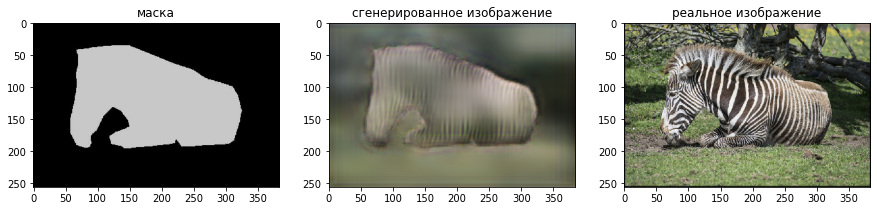

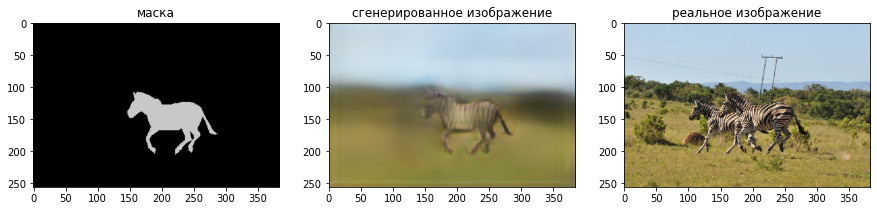

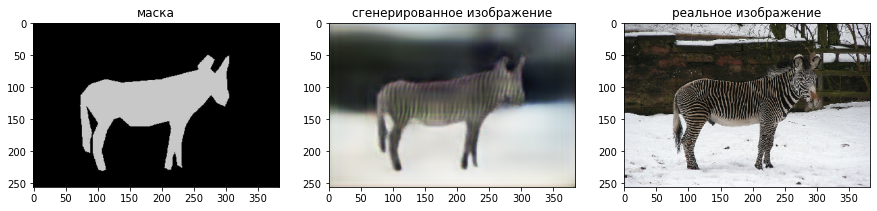

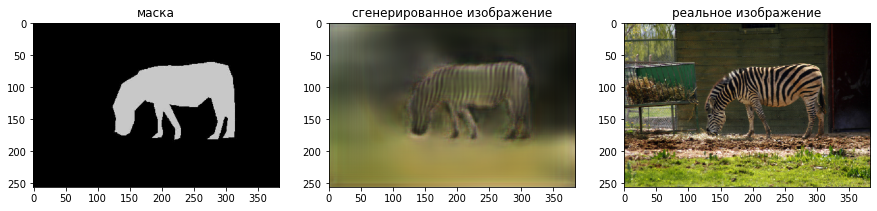

In [ ]:
for i in [15,100,240,320]:
   sample_image(gen, imgs, masks, i)

In [ ]:
# Сохраним веса

#gen.save_weights('/content/drive/My Drive/my_sample_data/COCO_Zebra/gen.h5')
gen.load_weights('/content/drive/My Drive/my_sample_data/COCO_Zebra/gen.h5')

#dis.save_weights('/content/drive/My Drive/my_sample_data/COCO_Zebra/dis.h5')
dis.load_weights('/content/drive/My Drive/my_sample_data/COCO_Zebra/dis.h5')